# Main analyses: Mapping spatial working memory in Schizophrenia

In [1]:
import numpy as np
import pandas as pd
import pickle
import functions as mf # my functions
import torch
from scipy import stats
import pingouin as pg
from statsmodels.stats.multitest import multipletests

## critical variables
# parcellation
PARC = 'cabn'

# subjects
subj_df = pd.read_csv('subject_list.txt', sep='\t', index_col = 0, header = 0)

# out directories
results_dir = '/projects/f_mc1689_1/ClinicalActFlow/data/results/N=93/'
figure_dir = '/projects/f_mc1689_1/ClinicalActFlow/docs/figures/N=93/'

# which connectivity type to use
fc_task = 'multitask-no-scap'
fc_method = 'pc_multregconn_100'

# task to analyze
task = 'scap'

# groups to analyze
groups = ['CTRL','SCHZ']

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/ljh118/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.2, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Plot helpers

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
PAL = sns.xkcd_palette(['grey','light orange'])
PAL2 = sns.xkcd_palette(['black','pale purple'])
net_PAL = sns.color_palette(['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                          'lightseagreen','yellow','orchid','r','peru','orange','olivedrab'])
#sns.set(font_scale=5) 

def roi_barplots(plot_df,figtitle=None):
    # draw a plot
    sns.set(style='ticks')

    # do plots
    plt.figure(figsize=(4,2))
    current_plot = plot_df.loc[plot_df['Effect']=='Neg']
    ax = sns.barplot(x='Roi', y='Activity',hue='Group',
               data=current_plot,palette=PAL)
    sns.despine()
    
    if figtitle is not None:
        plt.savefig(figtitle+'-1.jpeg',dpi=600)
        plt.savefig(figtitle+'-1.svg',dpi=600)
        
    plt.show()

    # do plots
    plt.figure(figsize=(2,2))
    current_plot = plot_df.loc[plot_df['Effect']=='Pos']
    ax = sns.barplot(x='Roi', y='Activity',hue='Group',
               data=current_plot,palette=PAL)
    sns.despine()

    if figtitle is not None:
        plt.savefig(figtitle+'-2.jpeg',dpi=600)
        plt.savefig(figtitle+'-2.svg',dpi=600)
        
    plt.show()

def roi_plots(plot_df,figtitle=None):
    # draw a plot
    plt.figure(figsize=(3.5,2.0))
    
    # roi list
    roi_list = plot_df.columns[1::].values
    
    # do plots
    for i,roi in enumerate(roi_list):
        plt.subplot(1,4,i+1)
        sns.swarmplot(x='group', y=roi,data=plot_df,size=2, color=".5", linewidth=0,alpha=0.75,zorder=0)
        ax = sns.boxplot(x='group', y=roi,data=plot_df,whis=0,fliersize=0,saturation=1,palette=sns.color_palette("Set2"),linewidth=1)
            
        ax.set_xticklabels(['HC','SC'])
        plt.ylim([-4,2])
        plt.xlabel(roi+1) #pythonic indexing correction
        sns.despine(trim=True)
        
        # Tweak the visual presentation
        if i==0:
            ax.set(ylabel='Activity (beta)')
        else:
            #ax.set(ylabel=None)
            remove_border(axes=ax,left=False,right=False)
        
    plt.tight_layout()
    
    if figtitle is not None:
        plt.savefig(figtitle+'.jpeg',dpi=600)
        plt.savefig(figtitle+'.svg',dpi=600)
    plt.show()
    
def wb_brain_plots(data,titles=None,inflation='very',figsize=(15,7.5)):
    plt.figure(figsize=figsize)
    
    for i in range(np.shape(data)[1]):
        mf.map_to_surface(data[:,i],'image',fliphemispheres=False)
        filename = '/projects/f_mc1689_1/ClinicalActFlow/docs/scripts/image.dscalar.nii'
        mf.print_wb_scene(filename,'image',inflation=inflation)

        plt.subplot(1,data.shape[1],i+1)
        img=mpimg.imread('image.png')
        imgplot = plt.imshow(img)
        mf.remove_border(left=False,bottom=False)
        if titles is not None:
            plt.title(titles[i],fontsize=16)
    plt.tight_layout()
    plt.show()
    
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

# Empirical results

In [3]:
# load the data
accuracy,reaction_time,_,_,task_labels = mf.load_scan_behaviour(subj_df.index,[task],subj_df['group'].values)
activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=[task])
network_order,_,network_def,networks = mf.get_network_info(PARC)
n_roi = activity['scap']['CTRL'].shape[0]

Task| scap Data loaded: 100.0 %


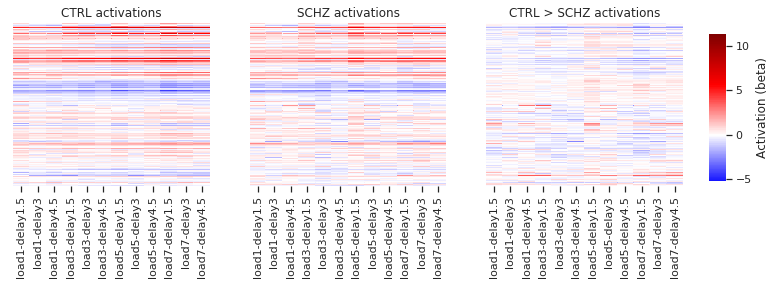

In [4]:
# plot all activation conditions
data1 = np.mean(activity[task]['CTRL'],axis=2)
data2 = np.mean(activity[task]['SCHZ'],axis=2)
datamin=min(np.array([min(data1.flatten()),min(data2.flatten())]))
datamax=max(np.array([max(data1.flatten()),max(data2.flatten())]))

data1 = np.squeeze(data1[network_order,:])
data2 = np.squeeze(data2[network_order,:])
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[12,3])
cbar_ax = fig.add_axes([0.93, .15, .02, .68])
ax1 = sns.heatmap(data1,ax=axn[0],center=0,cmap='seismic',cbar=False,yticklabels=[],xticklabels=task_labels[task],vmin=datamin,vmax=datamax)
ax1.title.set_text('CTRL activations')
ax2 = sns.heatmap(data2,ax=axn[1],center=0,cmap='seismic',cbar=True,yticklabels=[],xticklabels=task_labels[task],vmin=datamin,vmax=datamax,
                  cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (beta)'})
ax2.title.set_text('SCHZ activations')
ax3 = sns.heatmap(data2-data1,ax=axn[2],center=0,cmap='seismic',cbar=True,yticklabels=[],xticklabels=task_labels[task],vmin=datamin,vmax=datamax,
                  cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (beta)'})
ax3.title.set_text('CTRL > SCHZ activations')
plt.savefig(figure_dir+'GLM-all_activity.jpeg',dpi=600)
plt.savefig(figure_dir+'GLM-all_activity.svg',dpi=600)
plt.show()

## Activity: Network level t-tests

In [5]:
network_order,_,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
# WM x group interaction
hc = np.mean(activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(activity[task]['CTRL'][:,0:6,:],axis=1)
sz = np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1)

df_plot = pd.DataFrame()
x = np.zeros((hc.shape[1],12))
y = np.zeros((sz.shape[1],12))
for i,net in enumerate(np.unique(network_def)):
    net_idx = network_def==net
    
    x[:,i] = np.mean(hc[net_idx,:],axis=0)
    y[:,i] = np.mean(sz[net_idx,:],axis=0)
    
    #data for plot
    df = pd.DataFrame()
    df['Activity'] = x[:,i]
    df['Group'] = 'HC'
    df['Network'] = networks[int(net)-1]
    df_plot = pd.concat([df_plot,df])
    
    df = pd.DataFrame()
    df['Activity'] = y[:,i]
    df['Group'] = 'SZ'
    df['Network'] = networks[int(net)-1]
    df_plot = pd.concat([df_plot,df])
    
#t-test
t,pFWE = mf.ttest_ind_FWE(y,x,n_perm=2000,equal_var=False,random_seed=None)
print('FDR Sig networks=',np.array(networks)[pFWE<0.05])
print('t=',t[pFWE<0.05],', p=',pFWE[pFWE<0.05])

Observations in g1: 36 | Variables in g1: 12
Observations in g2: 93 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
FDR Sig networks= ['dmn']
t= [2.8489933] , p= [0.0265]


### Boxplot

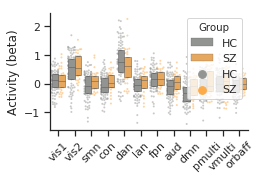

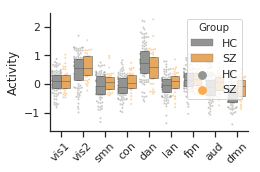

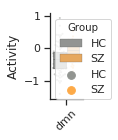

In [6]:
sns.set(style='ticks')

plt.figure(figsize=cm2inch(9.0,5.5))
sns.boxplot(x='Network',y='Activity',hue='Group',data=df_plot,orient='v',palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(x='Network',y='Activity',hue='Group',data=df_plot,size=2,orient='v',palette=PAL,dodge=True,zorder=0,alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('Activity (beta)')
plt.xlabel(None)
sns.despine()
plt.savefig(figure_dir+'GLM-nets-all.svg',dpi=600,bbox_inches='tight',pad_inches=1)
plt.show()

df = df_plot[(df_plot.Network=='vis1')|
             (df_plot.Network=='vis2')|(df_plot.Network=='smn')|
             (df_plot.Network=='smn')|(df_plot.Network=='con')|
            (df_plot.Network=='dan')|(df_plot.Network=='lan')|
            (df_plot.Network=='fpn')|(df_plot.Network=='aud')|
             (df_plot.Network=='dmn')]

plt.figure(figsize=cm2inch(9.0,5.5))
sns.boxplot(x='Network',y='Activity',hue='Group',data=df,orient='v',palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(x='Network',y='Activity',hue='Group',data=df,size=2,orient='v',palette=PAL,dodge=True,zorder=0,alpha=0.5)

plt.xticks(rotation=45)
plt.xlabel(None)
sns.despine()
plt.savefig(figure_dir+'GLM-nets.svg',dpi=600,bbox_inches='tight',pad_inches=1)
plt.show()

df = df_plot[(df_plot.Network=='dmn')]
plt.figure(figsize=cm2inch(1.5,4.0))
g=sns.boxplot(x='Network',y='Activity',hue='Group',data=df,orient='v',palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
g=sns.swarmplot(x='Network',y='Activity',hue='Group',data=df,size=2,orient='v',palette=PAL,dodge=True,zorder=0,alpha=0.5)

plt.xticks(rotation=45)
plt.xlabel(None)
sns.despine()
plt.savefig(figure_dir+'GLM-nets-dmnonly.svg',dpi=600,bbox_inches='tight',pad_inches=1)
plt.show()

## Activity: low v. high WM (sanity check)

In [7]:
# within subject t-test
hiWM = np.hstack((np.mean(activity[task]['CTRL'][:,6:12,:],axis=1),np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1)))
loWM = np.hstack((np.mean(activity[task]['CTRL'][:,0:6,:],axis=1),np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1)))
t,_maxT = mf.permutationTesting.maxT(hiWM-loWM,tail=0,permutations=1000)
print('No. of GLM fwe corrected regions = ',np.sum(abs(t)<_maxT))

No. of GLM fwe corrected regions =  520


### Brain plot

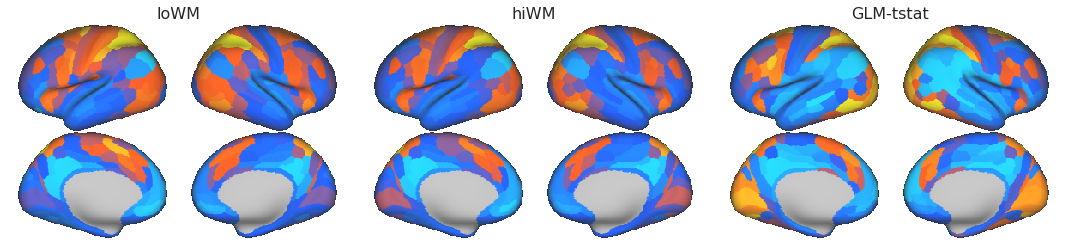

In [8]:
data = np.zeros((np.shape(t)[0],3))
data[:,0] = np.mean(loWM,axis=1)
data[:,1] = np.mean(hiWM,axis=1)
data[:,2] = t
wb_brain_plots(data,titles = ['loWM','hiWM','GLM-tstat'])

# save dscalar files out (slow)
do_brainplots = 0
if do_brainplots:
    # save connectome wb files in the figure folder
    mf.map_to_surface(np.mean(loWM,axis=1),figure_dir+'GLM-avgbeta_loWM')
    mf.map_to_surface(np.mean(hiWM,axis=1),figure_dir+'GLM-avgbeta_hiWM')
    mf.map_to_surface(t,figure_dir+'GLM-t-test-WM')

## Activity: WM x group interaction

In [9]:
# between groups t-test, FWE corrected
# contrast high versus low WM load conditions
x = np.mean(activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(activity[task]['CTRL'][:,0:6,:],axis=1)
y = np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1)

# the random seed is my birthyear :) Just to make it replicable - same results once perms are 20k and above
# switch y/x for SZ < HC
t,pFWE = mf.ttest_ind_FWE(y.T,x.T,n_perm=20000,equal_var=False,random_seed=1990)

print('No. of GLM fwe corrected regions = ',np.sum(pFWE<0.05))

Observations in g1: 36 | Variables in g1: 718
Observations in g2: 93 | Variables in g2: 718
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
No. of GLM fwe corrected regions =  4


## Regions of interest

In [10]:
roi_list = np.where(pFWE<0.05)[0]

# manually add one region showing an opposing effect
#roi_list = np.append(roi_list,(-t).argsort()[:1])

net_list = []
for i in network_def[roi_list]:
    net_list.append(networks[np.int(i-1)])
print('Roi list:',roi_list,'| pFWE:',np.round(pFWE[roi_list],3),'| t:',np.round(t[roi_list],3),'| Network affiliations:',net_list)

Roi list: [ 56 181 284 346] | pFWE: [0.033 0.048 0.048 0.002] | t: [4.038 3.932 3.933 4.719] | Network affiliations: ['con', 'vis2', 'con', 'con']


### Brain plots

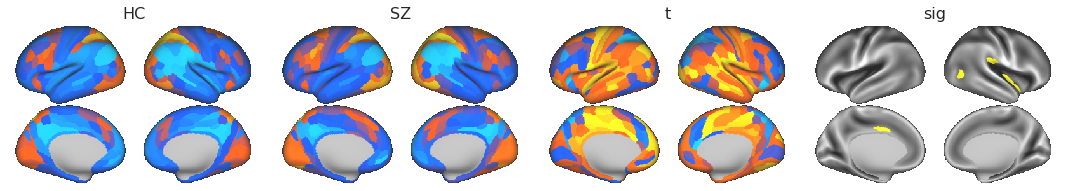

In [11]:
data = np.zeros((np.shape(t)[0],4))
data[:,0] = np.mean(x,axis=1)
data[:,1] = np.mean(y,axis=1)
data[:,2] = t
data[:,3] = pFWE < 0.05
wb_brain_plots(data,titles = ['HC','SZ','t','sig'])

# save dscalar files out (slow)
do_brainplots = 0

if do_brainplots:
    # plot mean responses
    print('Brain Activity difference in high v. low WM load')
    titles = ['CTRL-GLM','SCHZ-GLM','GLM-tstat','ROI_t','ROI']
    data = np.zeros((np.shape(x)[0],4))
    data[:,0] = np.mean(x,axis=1)
    data[:,1] = np.mean(y,axis=1)
    data[:,2] = t
    for i,roi in enumerate(roi_list):
        data[roi,3] = 1

    wb_brain_plots(data,titles=titles)

    # save connectome wb files in the figure folder
    mf.map_to_surface(np.mean(x,axis=1),figure_dir+'GLM-avgbeta_CTRL')
    mf.map_to_surface(np.mean(y,axis=1),figure_dir+'GLM-avgbeta_SCHZ')
    mf.map_to_surface(t,figure_dir+'GLM-t-test')
    mf.map_to_surface(data[:,3],figure_dir+'GLM-sig-mask')

### Roi plots

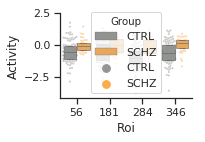

In [12]:
df_plot = pd.DataFrame()
for roi in roi_list:
    for group in ['CTRL','SCHZ']:
        df = pd.DataFrame()
        df['Activity'] = np.mean(activity[task][group][roi,6:12,:],axis=0) - np.mean(activity[task][group][roi,0:6,:],axis=0)
        df['Group'] = group
        df['Roi'] = roi
        df_plot = pd.concat([df_plot,df])
        
plt.figure(figsize=cm2inch(6.0,4.0))
sns.boxplot(y='Activity',x='Roi',hue='Group',data=df_plot,palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(y='Activity',x='Roi',hue='Group',data=df_plot,size=2,palette=PAL,dodge=True,zorder=0,alpha=0.5)
sns.despine()
plt.savefig(figure_dir+'GLM_roi-real.jpeg',dpi=600)
plt.savefig(figure_dir+'GLM_roi-real.svg',dpi=600)

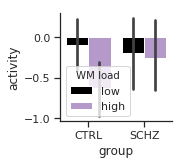

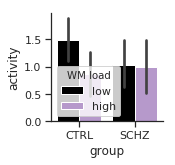

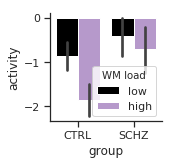

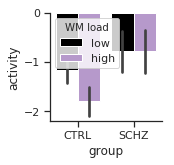

In [13]:
for roi in roi_list:
    plt.figure(figsize=(2,2))
    df_plot = pd.DataFrame()
    
    for group in ['CTRL','SCHZ']:
        for i, cond in enumerate(['low','high']):
            df = pd.DataFrame()
            if cond=='high':
                df['activity'] = np.mean(activity[task][group][roi,6:12,:],axis=0)
            else:
                df['activity'] = np.mean(activity[task][group][roi,0:6,:],axis=0)
            df['group'] = group
            df['WM load'] = cond
            df_plot = pd.concat([df_plot,df])
    sns.barplot(y='activity',x='group',hue='WM load',data=df_plot,palette=PAL2)
    #sns.swarmplot(y='activity',x='group',hue='WM load',data=df_plot,dodge=True,palette=PAL)
    sns.despine()

# Functional connectivity

In [14]:
# load fc data
fc,fc_all = mf.load_fc(subj_df,TASKS=[fc_task],PARC=PARC,fc_method=fc_method)
network_order,network_cols,network_def,networks = mf.get_network_info(PARC,subcortical_split=True)

Task| multitask-no-scap Data loaded: 100.0 %


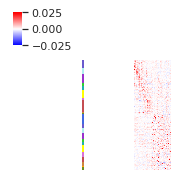

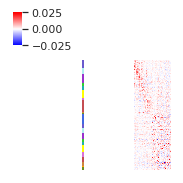

In [15]:
#plot FC matrices
for group in ['CTRL','SCHZ']:
    data = fc[fc_task][group]
    data = np.mean(data,axis=2)
    data = data[network_order,network_order.T]
    plot_df = pd.DataFrame(data=data)

    ax = sns.clustermap(data=plot_df,
                        row_cluster=False,col_cluster=False,
                        row_colors=network_cols,col_colors=None,
                        xticklabels=False,yticklabels=False,
                        figsize=(2.5,2.5),center=0,cmap='bwr',vmin=-0.025,vmax=0.025)

    plt.savefig(figure_dir+'FC-avg'+group+'.jpeg',dpi=600)
    #plt.savefig(figure_dir+'FC-avg'+group+'.svg',dpi=600) # very slow!

In [16]:
# FC stats
do_plots = 0

for roi in roi_list:
    print(roi)
    x = fc[fc_task]['CTRL'][roi,:,:]
    x = np.delete(x,roi,axis=0)
    y = fc[fc_task]['SCHZ'][roi,:,:]
    y = np.delete(y,roi,axis=0)
    
    idx = range(718)
    idx = np.delete(idx,roi)
    
    t = np.zeros((718))
    pFWE = np.ones((718))
    # flipped such that SZ < HC
    t[idx],pFWE[idx] = mf.ttest_ind_FWE(y.T,x.T,n_perm=20000,equal_var=False)
    
    print('\tNregions pFWE:',sum(pFWE<0.05))
    print('\tSig Regions:',np.where(pFWE<0.05))
    print('\tT vals:',t[pFWE<0.05])
    print('\tP vals:',pFWE[pFWE<0.05])
    
    try:
        x = fc[fc_task]['CTRL'][roi,:,:]
        y = fc[fc_task]['SCHZ'][roi,:,:]

        for test in np.where(pFWE<0.05)[0]:
            print(test)
            res = pg.ttest(x[test,:].T,y[test,:].T)
            display(res)
            
    except:
        print('no t-test results to print')
    
    #print the results out to brain files
    if do_plots:
        titles = ['FC-avg-CTRL-'+str(roi),'FC-avg-SCHZ-'+str(roi),'FC-tstat-'+str(roi),'FC-ROI-'+str(roi)]
        data = np.zeros((718,4))
        data[:,0] = np.mean(fc[fc_task]['CTRL'][roi,:,:],axis=1)
        data[:,1] = np.mean(fc[fc_task]['SCHZ'][roi,:,:],axis=1)
        data[:,2] = t
        data[np.where(pFWE<0.05),3] = 1
        #wb_brain_plots(data,titles=titles)
        for i in range(data.shape[1]):
            mf.map_to_surface(data[:,i],figure_dir+titles[i])

56
Observations in g1: 36 | Variables in g1: 717
Observations in g2: 93 | Variables in g2: 717
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
	P vals: []
181
Observations in g1: 36 | Variables in g1: 717
Observations in g2: 93 | Variables in g2: 717
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 2
	Sig Regions: (array([588, 603]),)
	T vals: [4.25450609 4.0149632 ]
	P vals: [0.01855 0.04095]
588


T    dof       tail     p-val          CI95%  cohen-d     BF10  \
T-test -4.255  76.38  two-sided  0.000059  [-0.01, -0.0]    0.769  486.193   

        power  
T-test  0.973

603


T    dof       tail     p-val         CI95%  cohen-d     BF10  \
T-test -4.015  72.57  two-sided  0.000143  [-0.0, -0.0]    0.742  214.997   

        power  
T-test  0.963

284
Observations in g1: 36 | Variables in g1: 717
Observations in g2: 93 | Variables in g2: 717
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
	P vals: []
346
Observations in g1: 36 | Variables in g1: 717
Observations in g2: 93 | Variables in g2: 717
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 1
	Sig Regions: (array([236]),)
	T vals: [-4.39043835]
	P vals: [0.0121]
236


T    dof       tail     p-val       CI95%  cohen-d     BF10  power
T-test  4.39  98.33  two-sided  0.000029  [0.0, 0.0]    0.715  785.756  0.951

In [17]:
# test within/between networks
_,_,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
x_net_weights = np.zeros((int(max(network_def)),93))
y_net_weights = np.zeros((int(max(network_def)),36))
# df_plot = pd.DataFrame()
# implicated_nets = {}

for i,roi in enumerate(roi_list):
    x = fc[fc_task]['CTRL'][roi,:,:]
    x = np.delete(x,roi,axis=0)
    y = fc[fc_task]['SCHZ'][roi,:,:]
    y = np.delete(y,roi,axis=0)

    
    for i,net1 in enumerate(np.unique(network_def)):
        net_idx = network_def==net
        net_idx = np.delete(net_idx,roi,axis=0)
        x_net_weights[i,:] = np.mean(x[net_idx,:],axis=0)
        y_net_weights[i,:] = np.mean(y[net_idx,:],axis=0)
    
    t,pFWE = mf.ttest_ind_FWE(x_net_weights.T,y_net_weights.T,n_perm=10000,equal_var=False,random_seed=None)
    print('\tNregions pFWE:',sum(pFWE<0.05))
    print('\tSig Regions:',np.where(pFWE<0.05))
    print('\tT vals:',t[pFWE<0.05])
    
#     plt.plot(np.mean(x_net_weights,axis=1))
#     plt.plot(np.mean(y_net_weights,axis=1))
#     plt.show()

Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions 

In [18]:
# test within networks
_,_,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
x_net_weights = np.zeros((int(max(network_def)),93))
y_net_weights = np.zeros((int(max(network_def)),36))
# df_plot = pd.DataFrame()
# implicated_nets = {}

for i,roi in enumerate(roi_list):
    x = fc[fc_task]['CTRL'][roi,:,:]
    x = np.delete(x,roi,axis=0)
    y = fc[fc_task]['SCHZ'][roi,:,:]
    y = np.delete(y,roi,axis=0)

    
    for i,net in enumerate(np.unique(network_def)):
        net_idx = network_def==net
        net_idx = np.delete(net_idx,roi,axis=0)
        x_net_weights[i,:] = np.mean(x[net_idx,:],axis=0)
        y_net_weights[i,:] = np.mean(y[net_idx,:],axis=0)
    
    t,pFWE = mf.ttest_ind_FWE(x_net_weights.T,y_net_weights.T,n_perm=10000,equal_var=False,random_seed=None)
    print('\tNregions pFWE:',sum(pFWE<0.05))
    print('\tSig Regions:',np.where(pFWE<0.05))
    print('\tT vals:',t[pFWE<0.05])
    
#     plt.plot(np.mean(x_net_weights,axis=1))
#     plt.plot(np.mean(y_net_weights,axis=1))
#     plt.show()

Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions 

# Activity flow predictions
While holding out all "abnormal" regions identified above.

## Run (or load) Activity Flow

In [20]:
# whether to run or load
do_actflow = 0

# generate activity flow predictions seperately in each group
task = 'scap'
af_file = 'actflow-' + fc_task + '-' + fc_method + '.pickle'

if do_actflow:
    predicted_activity = {}
    predicted_activity[task] = {}
    actFlowWeights = {}
    actFlowWeights[task] = {}

    for group in ['CTRL','SCHZ']:
        print('Running act flow in',group)
        fc_data = fc[fc_task][group].copy()

        actPredVector = np.zeros((np.shape(activity[task][group])))
        n_nodes =  np.shape(actPredVector)[0]
        n_conditions = np.shape(actPredVector)[1]
        n_subs = np.shape(actPredVector)[2]
        act_weights_mat = np.zeros((n_nodes,n_nodes,n_conditions,n_subs))

        for condition in range(n_conditions):
            act_data = activity[task][group][:,condition,:].copy()

            for subj in range(np.shape(fc_data)[2]):
                actPredVector[:,condition,subj],act_weights_mat[:,:,condition,subj] = mf.actflowcalc_hold_out_roi(act_data[:,subj],fc_data[:,:,subj],held_out_roi=roi_list)

        predicted_activity[task][group] = actPredVector
        actFlowWeights[task][group] = act_weights_mat
    
    print('\tsaving actflow results')
    with open(results_dir + af_file, 'wb') as handle:
        pickle.dump([predicted_activity,actFlowWeights], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('\tloading actflow results')
    with open(results_dir + af_file, 'rb') as handle:
        _tmp = pickle.load(handle)
    predicted_activity = _tmp[0]
    actFlowWeights = _tmp[1]
print('Actflow finished')

	loading actflow results
Actflow finished


## Accuracy: whole brain

In [21]:
from scipy.stats import ttest_ind
# do stats on the activity flow predictions
r = {}
MAE = {}
MAPE = {}
Rsqr = {}
for group in ['CTRL','SCHZ']:
    # do the same contrast
    real = np.mean(activity['scap'][group][:,6:12,:],axis=1) - np.mean(activity['scap'][group][:,0:6,:],axis=1)
    pred = np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1)
    
    # do actflow statistics
    r[group] = []
    MAE[group] = []
    MAPE[group] = []
    Rsqr[group] = []
    r[group],rs,MAE[group],MAPE[group],Rsqr[group] = mf.actflow_tests(real,pred,normalise=False)
    
# compare the groups
print('between groups: r t-test')
print('\t',ttest_ind(r['CTRL'],r['SCHZ'],equal_var=False))
print('between groups: MAE t-test')
print('\t',ttest_ind(MAE['CTRL'],MAE['SCHZ'],equal_var=False))
print('between groups: Rsqr t-test')
print('\t',ttest_ind(Rsqr['CTRL'],Rsqr['SCHZ'],equal_var=False))

Mean r across subjs: 0.632 |1samp t: 57.19 p: 0.0
Mean MAE  across subjs: 0.619
Mean MAPE  across subjs: 355.741
Mean R^2  across subjs: 0.395 |1samp t: 25.99 p: 0.0
Mean r across subjs: 0.6 |1samp t: 31.39 p: 0.0
Mean MAE  across subjs: 0.606
Mean MAPE  across subjs: 419.693
Mean R^2  across subjs: 0.352 |1samp t: 13.62 p: 0.0
between groups: r t-test
	 Ttest_indResult(statistic=1.4521158005263402, pvalue=0.15169795344195092)
between groups: MAE t-test
	 Ttest_indResult(statistic=0.5961902633342645, pvalue=0.5536932301395519)
between groups: Rsqr t-test
	 Ttest_indResult(statistic=1.436386169466524, pvalue=0.15603099921485372)


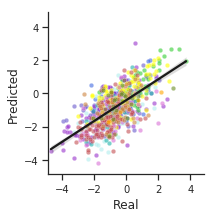

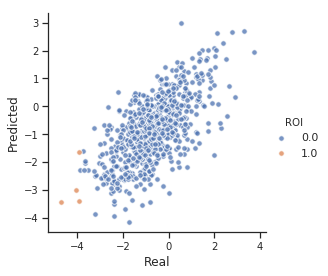

In [22]:
network_order,network_cols,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
# between groups t-test, FWE corrected
# contrast high versus low WM load conditions
x = np.mean(activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(activity[task]['CTRL'][:,0:6,:],axis=1)
y = np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1)
t_real,_= stats.ttest_ind(x.T,y.T,equal_var=False)

# predicted
x = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
y = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)

# the random seed is my birthyear :) Just to make it replicable - same results once perms are 20k and above
t_pred,_= stats.ttest_ind(x.T,y.T,equal_var=False)

plot_df = pd.DataFrame()
plot_df['Real'] = t_real
plot_df['Predicted'] = t_pred
plot_df['Network'] = network_def
roi_bin = np.zeros((np.shape(t_real)))
roi_bin[roi_list] = 1
plot_df['ROI'] = roi_bin

g = sns.lmplot(x='Real',y='Predicted',hue='Network',data=plot_df,fit_reg=False,height=3.2,legend_out=False,
               scatter_kws={'s':20,'alpha':0.60,'linewidths':0.25,'edgecolors':'w'},palette=net_PAL)
sns.regplot(x='Real', y='Predicted', data=plot_df, scatter=False, ax=g.axes[0, 0],color='k')
g.ax.tick_params(labelsize=10)
g.ax.get_legend().remove()
val = np.max(abs(np.hstack((t_real,t_pred))))+0.15
plt.xlim([val*-1,val])
plt.ylim([val*-1,val])
plt.savefig(figure_dir+'ActFlow-wholebrain-t-comp.svg')
plt.show()

g = sns.lmplot(x='Real',y='Predicted',hue='ROI',data=plot_df,fit_reg=False,height=4,legend_out=True,
               scatter_kws={'s':30,'alpha':0.75,'edgecolors':'w'})
g.ax.tick_params(labelsize=10)
plt.savefig(figure_dir+'ActFlow-wholebrain-t-comp-ROI.svg')
plt.show()

## Accuracy: network averages

In [23]:
# WM x group interaction
hc = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
sz = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)

df_plot = pd.DataFrame()
for net in np.unique(network_def):
    net_idx = network_def==net
    
    x = np.mean(hc[net_idx,:],axis=0)
    y = np.mean(sz[net_idx,:],axis=0)
    
    print(networks[int(net)-1],stats.ttest_ind(x,y,equal_var=False))
    
    df = pd.DataFrame()
    df['Activity'] = x
    df['Group'] = 'HC'
    df['Network'] = networks[int(net)-1]
    df_plot = pd.concat([df_plot,df])
    
    df = pd.DataFrame()
    df['Activity'] = y
    df['Group'] = 'SZ'
    df['Network'] = networks[int(net)-1]
    df_plot = pd.concat([df_plot,df])

vis1 Ttest_indResult(statistic=-0.9917972231880122, pvalue=0.3248733800112116)
vis2 Ttest_indResult(statistic=-1.2442693266003693, pvalue=0.2168142736640434)
smn Ttest_indResult(statistic=-2.464067387202288, pvalue=0.015670140690602068)
con Ttest_indResult(statistic=-1.8036650908195173, pvalue=0.07540171220672219)
dan Ttest_indResult(statistic=0.9001757458653391, pvalue=0.3713678982314147)
lan Ttest_indResult(statistic=-1.8392483137183961, pvalue=0.06943141794270843)
fpn Ttest_indResult(statistic=0.28971663549658266, pvalue=0.7728003855264833)
aud Ttest_indResult(statistic=-2.6451177086086433, pvalue=0.009924734924539496)
dmn Ttest_indResult(statistic=-3.0532454344839857, pvalue=0.0031382582296003367)
pmulti Ttest_indResult(statistic=-1.5652181476257305, pvalue=0.12324229035234328)
vmulti Ttest_indResult(statistic=-1.1259029793886455, pvalue=0.2648492525787365)
orbaff Ttest_indResult(statistic=-1.4552818871740836, pvalue=0.14990028774831132)


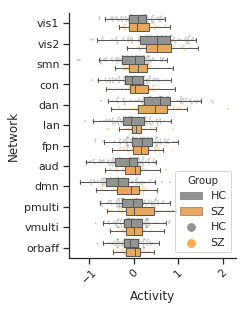

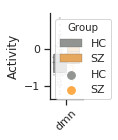

T    dof       tail     p-val           CI95%  cohen-d    BF10  \
T-test -3.053  74.49  two-sided  0.003138  [-0.34, -0.07]    0.558  12.261   

        power  
T-test  0.805

In [24]:
sns.set(style='ticks')
#sns.barplot(x='Network',y='Activity',hue='Group',data=df_plot,orient='v',palette=PAL)
plt.figure(figsize=(3,4.5))
sns.boxplot(x='Activity',y='Network',hue='Group',data=df_plot,orient='h',palette=PAL,linewidth=1,fliersize=0)
sns.swarmplot(x='Activity',y='Network',hue='Group',data=df_plot,size=2,orient='h',palette=PAL,dodge=True,zorder=0,alpha=0.5)
plt.xticks(rotation=45)
sns.despine()
plt.show()

df = df_plot[(df_plot.Network=='dmn')]
plt.figure(figsize=cm2inch(1.5,4.0))
g=sns.boxplot(x='Network',y='Activity',hue='Group',data=df,orient='v',palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
g=sns.swarmplot(x='Network',y='Activity',hue='Group',data=df,size=2,orient='v',palette=PAL,dodge=True,zorder=0,alpha=0.5)

plt.xticks(rotation=45)
plt.xlabel(None)
sns.despine()
plt.savefig(figure_dir+'GLM-nets-dmnonly-pred.svg',dpi=600,bbox_inches='tight',pad_inches=1)
plt.show()
display(pg.ttest(df[df['Group']=='HC'].Activity.values,df[df['Group']=='SZ'].Activity.values))

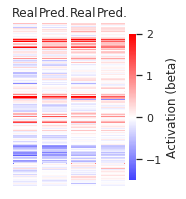

In [25]:
# plot the avg betas
ax_count = 0
fig, axn = plt.subplots(1, 4, sharex=True, sharey=True, figsize=[2,3])

for group in ['CTRL','SCHZ']:
    # do the same contrast
    real = np.mean(activity['scap'][group][:,6:12,:],axis=1) - np.mean(activity['scap'][group][:,0:6,:],axis=1)
    pred = np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1)
    
    # do the plot
    datamin = -1.5
    datamax = 2
    data1 = np.mean(real,axis=1)
    data1 = data1[network_order]

    data2 = np.mean(pred,axis=1)
    data2 = data2[network_order]
    

    ax1 = sns.heatmap(data1,ax=axn[ax_count],center=0,cmap='bwr',cbar=False,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax)
    ax1.title.set_text('Real')
    ax_count = ax_count+1
    
    if ax_count==3:
        cbar_ax = fig.add_axes([0.93, .15, .05, .68])
        ax2 = sns.heatmap(data2,ax=axn[ax_count],center=0,cmap='bwr',cbar=True,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax,
                      cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (beta)'})
    else:
        ax2 = sns.heatmap(data2,ax=axn[ax_count],center=0,cmap='bwr',cbar=False,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax)
    
    ax2.title.set_text('Pred.')
    ax_count = ax_count+1
    
plt.savefig(figure_dir+'ActFlow-wholebrain-avg-comp.jpeg')
plt.savefig(figure_dir+'ActFlow-wholebrain-avg-comp.svg')

# # plot a network colorbar
# cb_data = np.hstack((data1,data2))
# plot_df = pd.DataFrame(data=cb_data)

# ax = sns.clustermap(data=plot_df,row_cluster=False,col_cluster=False,
#                     row_colors=network_cols,col_colors=None,
#                     xticklabels=False,yticklabels=False,
#                     figsize=(1,4),center=0)
# plt.savefig(figure_dir+'ActFlow-wholebrain-avg-comp_colorbar.svg')

## Accuracy: target regions

In [26]:
# between groups t-test, FDR corrected - replication of the original analysis
x = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
y = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)

p = []
for roi in roi_list:
    res = pg.ttest(x[roi,:],y[roi,:])
    display(res.round(3))
    p.append(res['p-val'].values[0])

h,padj,_,_ = multipletests(np.array(p),method='bonferroni')
print('Bonferonni adjusted p-vals:',np.round(padj,3))
print('')

# test accuracy within each roi
r,MAE,MAPE,Rsqr = mf.roi_level_accuracy(activity,predicted_activity,roi_list)
print('Correlation within each roi=',r)
print('MAE within each roi=',MAE)
print('MAPE within each roi=',MAPE)
print('Rsqr within each roi=',Rsqr)

df_roi_metrics = pd.DataFrame()
df_roi_metrics['actflow-full'] = r
df_roi_metrics['metric'] = 'r'

T    dof       tail  p-val           CI95%  cohen-d    BF10  power
T-test -3.005  95.39  two-sided  0.003  [-0.54, -0.11]    0.496  10.819  0.707

T    dof       tail  p-val         CI95%  cohen-d  BF10  power
T-test -1.636  72.46  two-sided  0.106  [-0.4, 0.04]    0.302  0.68  0.333

T   dof       tail  p-val           CI95%  cohen-d    BF10  power
T-test -3.394  82.3  two-sided  0.001  [-0.65, -0.17]    0.594  31.236  0.852

T    dof       tail  p-val           CI95%  cohen-d    BF10  power
T-test -3.449  88.41  two-sided  0.001  [-0.54, -0.14]    0.587  36.673  0.843

Bonferonni adjusted p-vals: [0.014 0.425 0.004 0.003]

Correlation within each roi= [0.7809219  0.77292739 0.81224171 0.78278303]
MAE within each roi= [1.02628351 1.2237494  1.02358651 0.98583862]
MAPE within each roi= [ 143.60883767  388.01973576 1173.42733055  302.71312624]
Rsqr within each roi= [0.60756596 0.55348721 0.65785218 0.59860868]


### Brain plots

Brain Activity difference in high v. low WM load


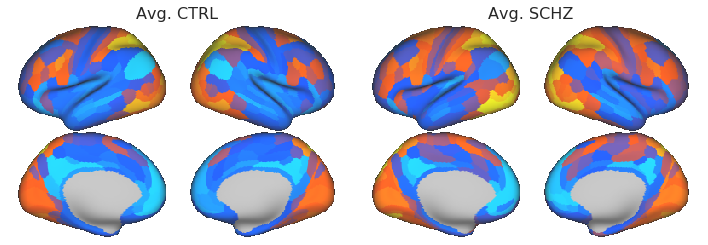

In [27]:
# plot mean responses
print('Brain Activity difference in high v. low WM load')
data = np.zeros((np.shape(x)[0],2))
data[:,0] = np.median(x,axis=1)
data[:,1] = np.median(y,axis=1)

wb_brain_plots(data,titles=['Avg. CTRL','Avg. SCHZ'],figsize=(10,5))

# save connectome wb files in the figure folder
mf.map_to_surface(np.mean(x,axis=1),figure_dir+'ActFlow-avgbeta_CTRL')
mf.map_to_surface(np.mean(y,axis=1),figure_dir+'ActFlow-avgbeta_SCHZ')

### Roi plots

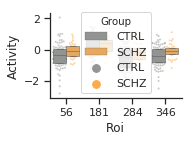

In [28]:
df_plot = pd.DataFrame()
for roi in roi_list:
    for group in ['CTRL','SCHZ']:
        df = pd.DataFrame()
        df['Activity'] = np.mean(predicted_activity[task][group][roi,6:12,:],axis=0) - np.mean(predicted_activity[task][group][roi,0:6,:],axis=0)
        df['Group'] = group
        df['Roi'] = roi
        df_plot = pd.concat([df_plot,df])
        
plt.figure(figsize=cm2inch(6.0,4.0))      
sns.boxplot(y='Activity',x='Roi',hue='Group',data=df_plot,palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(y='Activity',x='Roi',hue='Group',data=df_plot,size=2,palette=PAL,dodge=True,zorder=0,alpha=0.5)
sns.despine()
plt.savefig(figure_dir+'GLM_roi-pred.jpeg',dpi=600)
plt.savefig(figure_dir+'GLM_roi-pred.svg',dpi=600)

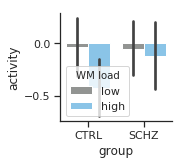

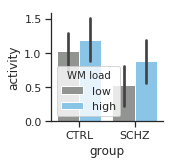

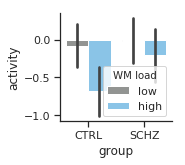

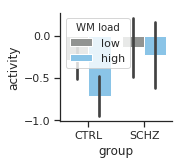

In [29]:
for roi in roi_list:
    plt.figure(figsize=(2,2))
    df_plot = pd.DataFrame()
    
    for group in ['CTRL','SCHZ']:
        for i, cond in enumerate(['low','high']):
            df = pd.DataFrame()
            if cond=='high':
                df['activity'] = np.mean(predicted_activity[task][group][roi,6:12,:],axis=0)
            else:
                df['activity'] = np.mean(predicted_activity[task][group][roi,0:6,:],axis=0)
            df['group'] = group
            df['WM load'] = cond
            df_plot = pd.concat([df_plot,df])
    sns.barplot(y='activity',x='group',hue='WM load',data=df_plot,palette=sns.xkcd_palette(['grey','lightblue']))
    #sns.swarmplot(y='activity',x='group',hue='WM load',data=df_plot,dodge=True,palette=PAL)
    sns.despine()

# Brain-behaviour correlations

In [106]:
# organise the behaviour
behav_type = 'acc' # or acc

if behav_type=='acc':
    # SCAP accuracy
    accuracy,reaction_time,_,_,task_labels = mf.load_scan_behaviour(subj_df.index,['scap'],subj_df['group'].values)
    scap_acc = np.hstack((np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0),\
                          np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0)))
elif behav_type=='d-prime':
    dprime,_,_,_ = mf.load_scap_dprime(subj_df.index,subj_df['group'].values)
    scap_acc = np.hstack((dprime['CTRL'],dprime['SCHZ']))

# get the individual difference data
_,beh_tsv_dict,_ = mf.beh_tsv_helper()
ind_diff_data,ind_diff_labels = mf.load_ind_diff_behaviour(subj_df.index, beh_tsv_dict)
#rint(ind_diff_labels)
ind_diff_data = np.hstack((ind_diff_data[:,subj_df['group']=='CTRL'],ind_diff_data[:,subj_df['group']=='SCHZ'])).T

# limit individual differences to cognitive control measures (i.e. across the whole sample)
ind_diff_data = ind_diff_data[:,29::]
ind_diff_labels = ind_diff_labels[29::]

# single subj x measure
behav_data = np.fliplr(np.hstack((ind_diff_data,scap_acc.reshape(len(scap_acc),-1))))
ind_diff_labels.insert(0,'scap')

In [107]:
activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=['scap'])
_,_,network_def,_ = mf.get_network_info(PARC,subcortical_split=False)

net_idx = network_def==9 #dmn
real_act = {}
pred_act = {}

# WM x group interaction
# real data
hc = np.mean(activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(activity[task]['CTRL'][:,0:6,:],axis=1)
sz = np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1)
real_act['dmn'] = np.hstack((np.mean(hc[net_idx,:],axis=0),np.mean(sz[net_idx,:],axis=0)))

for i,roi in enumerate(roi_list):
    real_act[roi] = np.hstack((hc[roi,:],sz[roi,:]))
real_act['roi-avg'] = np.hstack((np.mean(hc[roi_list,:],axis=0),np.mean(sz[roi_list,:],axis=0)))

hc = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
sz = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)
pred_act['dmn'] = np.hstack((np.mean(hc[net_idx,:],axis=0),np.mean(sz[net_idx,:],axis=0)))

for i,roi in enumerate(roi_list):
    pred_act[roi] = np.hstack((hc[roi,:],sz[roi,:]))
pred_act['roi-avg'] = np.hstack((np.mean(hc[roi_list,:],axis=0),np.mean(sz[roi_list,:],axis=0)))

Task| scap Data loaded: 100.0 %


In [108]:
r = []
p = []
for roi in real_act.keys():
    for i,beh in enumerate(range(len(ind_diff_labels))):
        _r,_p = stats.spearmanr(real_act[roi],behav_data[:,i])
        _r2,_p2 = stats.spearmanr(pred_act[roi],behav_data[:,i])
        if i==0:
            print(roi)
            print('\tReal scap corr:',np.round(_r,2),'p=',np.round(_p,4),'Bonf[5] adj p:',np.round(_p*5,4))
            print('\tPred scap corr:',np.round(_r2,2),'p=',np.round(_p2,4),'Bonf[5] adj p:',np.round(_p2*5,4))

        else:
            # save to a list to be FWE corrected
            r.append(_r)
            p.append(_p)
    if roi == 'roi-avg':
        # if correlating the roi average use the FWE correction across all vars
        # we only care about real activity in this correlation
        #q,maxR,pFWE = mf.maxR(behav_data.T, real_act[roi], alpha=.05, tail=0, permutations=10000, nproc=1, pvals=True)
        
        # FDR corrected
        r_all,p_all = stats.spearmanr(real_act[roi],behav_data)
        h0,pFDR,_,_ = multipletests(p_all[0,1::])
        df = pd.DataFrame()
        df['Measure'] = ind_diff_labels
        df['Correlation (r)'] = np.round(r_all[0,1::],2)
        df['pFDR'] = np.round(pFDR,2)
        df['Significant'] = pFDR < 0.05
        df.to_csv(results_dir+'Supp_table1.csv')

dmn
	Real scap corr: -0.29 p= 0.0009 Bonf[5] adj p: 0.0043
	Pred scap corr: -0.31 p= 0.0003 Bonf[5] adj p: 0.0017
56
	Real scap corr: -0.29 p= 0.0009 Bonf[5] adj p: 0.0043
	Pred scap corr: -0.25 p= 0.0046 Bonf[5] adj p: 0.0228
181
	Real scap corr: -0.26 p= 0.0024 Bonf[5] adj p: 0.0122
	Pred scap corr: 0.02 p= 0.8558 Bonf[5] adj p: 4.2788
284
	Real scap corr: -0.35 p= 0.0 Bonf[5] adj p: 0.0002
	Pred scap corr: -0.27 p= 0.0017 Bonf[5] adj p: 0.0083
346
	Real scap corr: -0.34 p= 0.0001 Bonf[5] adj p: 0.0004
	Pred scap corr: -0.17 p= 0.0509 Bonf[5] adj p: 0.2546
roi-avg
	Real scap corr: -0.37 p= 0.0 Bonf[5] adj p: 0.0001
	Pred scap corr: -0.19 p= 0.0294 Bonf[5] adj p: 0.147


## Roi Level

Not plotting roi average


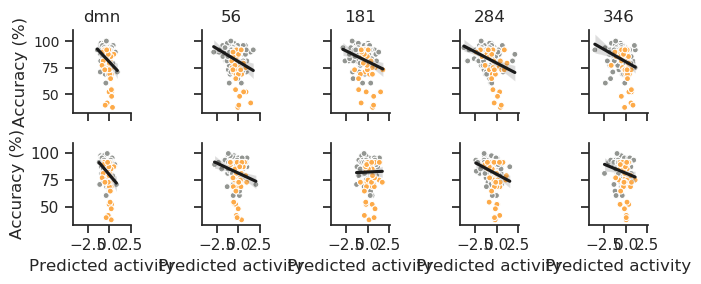

In [131]:
# general figure params
f, axes = plt.subplots(2, 5,sharey=True,sharex=True, figsize=(7, 3))

for i,label in enumerate(real_act.keys()):
    if label == 'roi-avg':
        print('Not plotting roi average')
    else:
        
        # prepare scatter plot
        plot_df = pd.DataFrame()
        plot_df['group'] = np.hstack((['HC']*hc.shape[1],['SZ']*sz.shape[1]))
        plot_df['Accuracy (%)'] = behav_data[:,0]*100
        plot_df['Activity'] = real_act[label]
        plot_df['Predicted activity'] = pred_act[label]
        
        # plot the real (left hand) figure
        g=sns.scatterplot(y='Accuracy (%)', x='Activity',hue='group', data=plot_df, 
              palette=PAL,ax=axes[0,i],size=15)
        sns.regplot(y='Accuracy (%)', x='Activity', data=plot_df, scatter=False,color='k',ax=axes[0,i])
        
        #subplot properties
        g.legend_.remove()
        axes[0,i].set_title(label)
        axes[0,i].tick_params(axis='both', which='major', labelsize=10)
        plt.yticks(ticks=[50,75,100])
        
        # plot the pred (right hand) figure
        g=sns.scatterplot(y='Accuracy (%)', x='Predicted activity',hue='group', data=plot_df, 
              palette=PAL,ax=axes[1,i],size=15)
        sns.regplot(y='Accuracy (%)', x='Predicted activity', data=plot_df, scatter=False,color='k',ax=axes[1,i])
        
        #subplot properties
        g.legend_.remove()

sns.despine()
plt.tight_layout()
plt.savefig(figure_dir+'brain-beh-pred.svg',dpi=600)
plt.show()

# Probing activity flow predictions
The activity flow mapping procedure relies on a simple formula:

_j’s predicted activity = sum of (i’s activity × Connectivity i-with-j)_

This is very similar to a linear regression equation where:

$$ y = X\beta+e$$

However, with activity flow there is no error/ intercept term.

Here the idea is to look at each individual "flow" parameter (_i’s activity × Connectivity i-with-j_) in our regions of interest. This is informative in two ways:
- How does each region (or networks) parameters add up to the final predicted activity?
- How does this differ between groups?

## Whole brain test

In [34]:
do_plots = 0
for i,roi in enumerate(roi_list):
    x = np.mean(actFlowWeights['scap']['CTRL'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['CTRL'][roi,:,0:6,:],axis=1)
    x = np.delete(x,roi_list,axis=0)
    y = np.mean(actFlowWeights['scap']['SCHZ'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['SCHZ'][roi,:,0:6,:],axis=1)
    y = np.delete(y,roi_list,axis=0)

    idx = range(718)
    idx = np.delete(idx,roi_list)
    
    t = np.zeros((718))
    pFWE = np.ones((718))
    t[idx],pFWE[idx] = mf.ttest_ind_FWE(y.T,x.T,n_perm=20000,equal_var=False)
    
    print('\tNregions pFWE:',sum(pFWE<0.05))
    print('\tSig Regions:',np.where(pFWE<0.05))
    print('\tT vals:',t[pFWE<0.05])
    print('\tP vals:',pFWE[pFWE<0.05])
    
    # print indepth statistics
    #for region
    try:
        x = np.mean(actFlowWeights['scap']['CTRL'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['CTRL'][roi,:,0:6,:],axis=1)
        y = np.mean(actFlowWeights['scap']['SCHZ'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['SCHZ'][roi,:,0:6,:],axis=1)

        for test in np.where(pFWE<0.05)[0]:
            print(test)
            res = pg.ttest(x[test,:].T,y[test,:].T)
            display(res)
            
    except:
        print('no t-test results to print')
    
        #print the results out to brain files
    if do_plots:
        titles = ['Actflow-weights-roi-'+str(roi+1)+'-avg_CTRL',
                  'Actflow-weights-roi-'+str(roi+1)+'-avg_SCHZ',
                  'Actflow-weights-roi-'+str(roi+1)+'-tstat',
                  'Actflow-weights-roi-'+str(roi+1)+'-SigReg']
        data = np.zeros((718,4))
        data[:,0] = np.mean(np.mean(actFlowWeights['scap']['CTRL'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['CTRL'][roi,:,0:6,:],axis=1),axis=1)
        data[:,1] = np.mean(np.mean(actFlowWeights['scap']['SCHZ'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['SCHZ'][roi,:,0:6,:],axis=1),axis=1)
        data[:,2] = t
        data[np.where(pFWE<0.05),3] = 1
        #wb_brain_plots(data,titles=titles)
        for i in range(data.shape[1]):
            mf.map_to_surface(data[:,i],figure_dir+titles[i])

Observations in g1: 36 | Variables in g1: 714
Observations in g2: 93 | Variables in g2: 714
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 1
	Sig Regions: (array([239]),)
	T vals: [3.86835124]
	P vals: [0.03825]
239


T    dof       tail     p-val          CI95%  cohen-d     BF10  \
T-test -3.868  61.48  two-sided  0.000267  [-0.01, -0.0]    0.773  133.034   

        power  
T-test  0.974

Observations in g1: 36 | Variables in g1: 714
Observations in g2: 93 | Variables in g2: 714
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 0
	Sig Regions: (array([], dtype=int64),)
	T vals: []
	P vals: []
Observations in g1: 36 | Variables in g1: 714
Observations in g2: 93 | Variables in g2: 714
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 2
	Sig Regions: (array([222, 239]),)
	T vals: [3.85657779 3.90842749]
	P vals: [0.04315 0.03435]
222


T     dof       tail     p-val          CI95%  cohen-d     BF10  \
T-test -3.857  116.42  two-sided  0.000189  [-0.01, -0.0]    0.583  128.087   

        power  
T-test  0.838

239


T   dof       tail     p-val          CI95%  cohen-d     BF10  \
T-test -3.908  79.0  two-sided  0.000195  [-0.01, -0.0]    0.696  151.461   

        power  
T-test  0.941

Observations in g1: 36 | Variables in g1: 714
Observations in g2: 93 | Variables in g2: 714
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
	Nregions pFWE: 2
	Sig Regions: (array([239, 324]),)
	T vals: [3.88253095 4.20122814]
	P vals: [0.0439 0.0119]
239


T    dof       tail    p-val          CI95%  cohen-d     BF10  \
T-test -3.883  81.06  two-sided  0.00021  [-0.01, -0.0]    0.684  139.264   

        power  
T-test  0.933

324


T    dof       tail     p-val           CI95%  cohen-d     BF10  \
T-test -4.201  88.33  two-sided  0.000063  [-0.02, -0.01]    0.715  404.147   

        power  
T-test  0.951

## Summing flows within networks

In [35]:
_,_,network_def,networks = mf.get_network_info(PARC,subcortical_split=False)
x_net_weights = np.zeros((int(max(network_def)),93))
y_net_weights = np.zeros((int(max(network_def)),36))
df_plot = pd.DataFrame()
implicated_nets = {}

for i,roi in enumerate(roi_list):
    x = np.mean(actFlowWeights['scap']['CTRL'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['CTRL'][roi,:,0:6,:],axis=1)
    y = np.mean(actFlowWeights['scap']['SCHZ'][roi,:,6:12,:],axis=1) - np.mean(actFlowWeights['scap']['SCHZ'][roi,:,0:6,:],axis=1)
    
    x[roi_list,:] = 0
    y[roi_list,:] = 0
    
    for i,net in enumerate(np.unique(network_def)):
        net_idx = network_def==net
        x_net_weights[i,:] = np.sum(x[net_idx,:],axis=0)
        y_net_weights[i,:] = np.sum(y[net_idx,:],axis=0)
    
    t,pFWE = mf.ttest_ind_FWE(x_net_weights.T,y_net_weights.T,n_perm=1000,equal_var=False,random_seed=None)

    #save the roi
    implicated_nets[roi] = []
    implicated_nets[roi] = np.where(pFWE<0.05)[0]
    
    #print results
    print(roi,sum(pFWE<0.05))
    print('\tcorrected pvalue=',pFWE[pFWE<0.05])
    print('\tnets:',np.where(pFWE<0.05)[0])
    
    # do additional stats
    for net in np.where(pFWE<0.05)[0]:
        display(pg.ttest(x_net_weights[net,:],y_net_weights[net,:]))
    
    # create a df for plotting
    for i,net in enumerate(networks):
        net_idx = network_def==i+1
        
        df = pd.DataFrame()
        df['weights'] = np.sum(x[net_idx,:],axis=0)
        df['group'] = ['HC'] * len(df)
        df['roi'] = roi
        df['Network'] = net
        df_plot = pd.concat([df_plot,df],sort=False)
        
        df = pd.DataFrame()
        df['weights'] = np.sum(y[net_idx,:],axis=0)
        df['group'] = ['SZ'] * len(df)
        df['roi'] = roi
        df['Network'] = net
        df_plot = pd.concat([df_plot,df],sort=False)

Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
56 1
	corrected pvalue= [0.031]
	nets: [2]


T    dof       tail     p-val           CI95%  cohen-d   BF10  \
T-test -2.946  88.51  two-sided  0.004109  [-0.11, -0.02]    0.501  9.311   

        power  
T-test  0.716

Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
181 0
	corrected pvalue= []
	nets: []
Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
284 1
	corrected pvalue= [0.003]
	nets: [3]


T    dof       tail     p-val           CI95%  cohen-d     BF10  \
T-test -3.843  86.27  two-sided  0.000232  [-0.24, -0.08]     0.66  122.684   

        power  
T-test  0.916

Observations in g1: 93 | Variables in g1: 12
Observations in g2: 36 | Variables in g2: 12
Starting permutations...
	Finished permutations...
Desired Alpha level: 0.05 | Estimated FWE alpha: 0.05
346 3
	corrected pvalue= [0.033 0.001 0.002]
	nets: [4 5 6]


T    dof       tail     p-val           CI95%  cohen-d   BF10  \
T-test -2.701  75.55  two-sided  0.008529  [-0.08, -0.01]     0.49  5.123   

        power  
T-test  0.698

T    dof       tail     p-val           CI95%  cohen-d     BF10  \
T-test -4.095  83.74  two-sided  0.000097  [-0.06, -0.02]    0.712  281.042   

        power  
T-test  0.949

T    dof       tail     p-val           CI95%  cohen-d    BF10  \
T-test -3.615  74.72  two-sided  0.000542  [-0.09, -0.03]    0.659  60.232   

        power  
T-test  0.915

### Polar plots

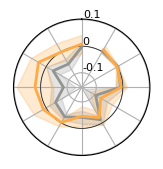

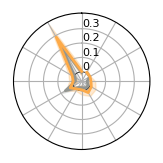

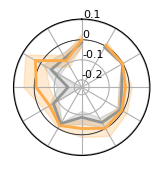

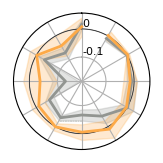

In [36]:
import statsmodels.stats.api as sms
for i,roi in enumerate(roi_list):
    df_roi = df_plot.loc[df_plot.roi==roi]
    
    plt.style.use('default')
    # function
    error_alpha=0.25

    #set up the polar plot
    n_nets = len(df_roi['Network'].unique())

    #convert index to radians
    radians = np.linspace(0, 2 * np.pi, num=n_nets, endpoint=False)

    plt.figure(figsize=cm2inch(4.5, 4.5))
    ax = plt.axes(polar=True)
    ax.set_theta_zero_location('N')
    
    # plot a solid line around 0
    r = np.arange(0,2*np.pi,0.01)
    y = np.zeros((len(r)))
    ax.plot(r, y,'k',lw=0.5)
    
    # Set up labels
    ax.set_xticks(radians)
    ax.set_xticklabels('', size=0)
    ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3])
    ax.set_yticklabels([-0.2,-0.1,0,0.1,0.2,0.3], size=8)
    # move the 'y-axis' to a gap
    ax.set_rlabel_position(-1)

    for i,g in enumerate(df_roi['group'].unique()):
        y = []
        y_ci_lo = []
        y_ci_hi = []

        # get the data from df
        for net in df_roi['Network'].unique():
            data = df_roi[(df_roi.group==g) & (df_roi.Network==net)].weights.values
            y.append(np.mean(data))
            lo,hi = sms.DescrStatsW(data).tconfint_mean()
            y_ci_lo.append(lo)
            y_ci_hi.append(hi)

        # plot the mean
        ax.plot(radians, y,lw=2,color=PAL[i])
        #ax.tick_params(labelsize=8)

        # fill in confidence intervals
        ax.fill_between(radians, y_ci_lo, y_ci_hi, alpha=error_alpha,color=PAL[i])
    plt.savefig(figure_dir+'network-flow-roi-'+str(roi)+'.svg',dpi=600)
    plt.show()

# Simulating FC alteration

## Estimating FC with gradient descent regression (pytorch)

In [60]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from tqdm import tqdm

altered_actflow = np.zeros((36,len(roi_list)))
new_fc = np.zeros((36,718,len(roi_list)))
fc_diff_weights_all = new_fc.copy()
weights_all = np.zeros((36,718,len(roi_list)))
altered_actflow = np.zeros((36,12,len(roi_list)))

cv = KFold(n_splits=4,shuffle=True,random_state=1990) # my birth year :D

# define X (features)
X = (np.mean(activity['scap']['SCHZ'][:,6:12,:],axis=1) - np.mean(activity['scap']['SCHZ'][:,0:6,:],axis=1)).T
X[:,roi_list] = 0

for train_index, test_index in cv.split(X):
    
    for r,roi in enumerate(roi_list):
        y = np.mean(activity['scap']['CTRL'][roi,6:12,:],axis=0) - np.mean(activity['scap']['CTRL'][roi,0:6,:],axis=0)
        y = np.mean(y)
        y = np.tile(y,36).reshape(-1,1)



        # get real fc
        fc_vec = fc[fc_task]['SCHZ'][roi,:,:]
            
        ## Activity prediction model
        # split into training and testing
        y_train = y[train_index,:]
        y_test = y[test_index,:]

        X_train = X[train_index,:]
        X_test = X[test_index,:]

        fc_vec_train = np.mean(fc_vec[:,train_index],axis=1)
        fc_vec_test = fc_vec[:,test_index]

        # run the HC -> SZ model fitting
        model,weights = mf.fc_grad_desc(X_train,np.ravel(y_train),fc_vec_train,num_epochs=200,batch_size=9,bias=False,lr=1e-3,loss_cutoff=0,verbose=False)

        # save the weights out across folds/iterations
        weights_all[test_index,:,r] = weights.copy()

        # reinstate fc_vec
        fc_vec_train = np.mean(fc_vec[:,train_index],axis=1)

        # calculate the fc difference that needs to be applied to alter the fc
        fc_diff_weights = weights - fc_vec_train

        # apply the fc differences to held out test data
        new_fc[test_index,:,r] = (fc_vec_test + fc_diff_weights.reshape(-1,1)).T
        
## perform tests of fit
# instead of using e.g., R2 we are interested in how well it improves activity flow
for r,roi in enumerate(roi_list):
    print('ROI----',r,roi)
    # perform activity flow
    actPredVector = np.zeros((np.shape(activity[task]['SCHZ'])))
    n_nodes =  np.shape(actPredVector)[0]
    n_conditions = np.shape(actPredVector)[1]
    n_subs = np.shape(actPredVector)[2]
    act_weights_mat = np.zeros((n_nodes,n_nodes,n_conditions,n_subs))

    for condition in range(n_conditions):
        act_data = activity[task]['SCHZ'][:,condition,:].copy()

        # zero out held out regions
        act_data[roi_list,:] = 0

        for subj in range(np.shape(new_fc)[0]):
            altered_actflow[subj,condition,r] = np.sum(act_data[:,subj]*new_fc[subj,:,r])

    # statistically compare to original data
    a = np.mean(activity[task]['SCHZ'][roi,6:12,:],axis=0) - np.mean(activity[task]['SCHZ'][roi,0:6,:],axis=0)
    b = np.mean(altered_actflow[:,6:12,r] - altered_actflow[:,0:6,r],axis=1)
    df_stats = pg.ttest(a,b)
    print('Activation: Real SZ vs. altered SZ t-test')
    display(df_stats)

## brain-behaviour test 
# restart the cv folds...
# note that the SZ test subjects are always held out of the training.
# I think it is technically not circular to include them as these four activations
# are never used in the prediction, but I have left them out anyway

behav_pred_treat = np.zeros((36))  # using treatment data
behav_pred_af = np.zeros((36))  # using regular af data
for train_index, test_index in cv.split(X):
    
    ## create brain-behaviour model in train data only
    # total task accuracy
    behav_data = np.hstack((np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0),\
                          np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0)[train_index]))
    
    ctrl_act = np.mean(activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(activity[task]['CTRL'][:,0:6,:],axis=1)
    schz_act = (np.mean(activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(activity[task]['SCHZ'][:,0:6,:],axis=1))[:,train_index]
    
    # stack regardless of group
    act_data = np.zeros((len(behav_data),len(roi_list)))
    for r,roi in enumerate(roi_list):
        act_data[:,r] = np.hstack((ctrl_act[roi,:],schz_act[roi,:]))
    
    # create SVM model with default parameters to predict behaviour from activity
    svm_model = SVR(gamma='scale',epsilon=0.01)
    svm_model.fit(act_data,behav_data)

    # Make behavioural predictions with altered activations in test subjects
    alt_act = np.mean(altered_actflow[:,6:12,:] - altered_actflow[:,0:6,:],axis=1)
    behav_pred_treat[test_index] = svm_model.predict(alt_act[test_index,:])
    
    # Make predictions in the original activity flow data
    # new analysis!
    af_schz_act = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)
    af_schz_act = af_schz_act[roi_list,:].T
    behav_pred_af[test_index] = svm_model.predict(af_schz_act[test_index,:])
    
# statistical test between empriical SZ and altered 'treatment' SZ
a = np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0)
b = behav_pred_treat.copy()
df_stats = pg.ttest(a,b)
print('Behaviour: Real SZ vs. altered SZ t-test')
display(df_stats)

# statistical test between empriical HC and AF SZ
a = np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0)
b = behav_pred_af.copy()
df_stats = pg.ttest(a,b)
print('Behaviour: Real HC vs. AF SZ t-test')
display(df_stats)

# statistical test between empriical HC and AF SZ
a = np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0)
b = behav_pred_af.copy()
df_stats = pg.ttest(a,b)
print('Behaviour: Real SZ vs. AF SZ t-test')
display(df_stats)

print('% HC-emp mean > af=',np.round(np.mean(accuracy['scap']['CTRL'])*100-np.mean(behav_pred_af)*100,2))
print('% SZ-emp mean > af=',np.round(np.mean(accuracy['scap']['SCHZ'])*100-np.mean(behav_pred_af)*100,2))
print('% HC-emp mean > alt af=',np.round(np.mean(accuracy['scap']['CTRL'])*100-np.mean(behav_pred_treat)*100,2))
print('% SZ-emp mean > alt af=',np.round(np.mean(accuracy['scap']['SCHZ'])*100-np.mean(behav_pred_treat)*100,2))

ROI---- 0 56
Activation: Real SZ vs. altered SZ t-test


T  dof       tail     p-val         CI95%  cohen-d   BF10  power
T-test  2.964   70  two-sided  0.004149  [0.11, 0.57]    0.699  9.329  0.832

ROI---- 1 181
Activation: Real SZ vs. altered SZ t-test


T  dof       tail     p-val         CI95%  cohen-d   BF10  power
T-test  2.077   70  two-sided  0.041472  [0.01, 0.59]     0.49  1.509  0.535

ROI---- 2 284
Activation: Real SZ vs. altered SZ t-test


T  dof       tail     p-val         CI95%  cohen-d  BF10  power
T-test  2.396   70  two-sided  0.019249  [0.07, 0.81]    0.565  2.72  0.657

ROI---- 3 346
Activation: Real SZ vs. altered SZ t-test


T  dof       tail     p-val       CI95%  cohen-d    BF10  power
T-test  3.615   70  two-sided  0.000563  [0.2, 0.7]    0.852  49.906  0.946

Behaviour: Real SZ vs. altered SZ t-test


T  dof       tail    p-val           CI95%  cohen-d      BF10  \
T-test -4.758   70  two-sided  0.00001  [-0.18, -0.07]    1.122  1683.574   

        power  
T-test  0.997

Behaviour: Real HC vs. AF SZ t-test


T    dof       tail     p-val         CI95%  cohen-d     BF10  \
T-test  4.238  76.51  two-sided  0.000062  [0.03, 0.09]    0.765  459.583   

        power  
T-test  0.972

Behaviour: Real SZ vs. AF SZ t-test


T  dof       tail     p-val           CI95%  cohen-d  BF10  power
T-test -2.42   70  two-sided  0.018137  [-0.13, -0.01]     0.57  2.85  0.665

% HC-emp mean > af= 6.3
% SZ-emp mean > af= -6.9
% HC-emp mean > alt af= 0.41
% SZ-emp mean > alt af= -12.79


In [38]:
# correlations between average CTRL and average SZ FC
r_old = []
r_new = []
for i,roi in enumerate(roi_list):
    r,p = stats.pearsonr(np.mean(fc[fc_task]['CTRL'][roi,:,:],axis=1),
                         np.mean(fc[fc_task]['SCHZ'][roi,:,:],axis=1))
    r_old.append(r)

    r,p = stats.pearsonr(np.mean(fc[fc_task]['CTRL'][roi,:,:],axis=1),
                         np.mean(new_fc[:,:,i],axis=0))
    r_new.append(r)
print('Mean correlation in empirical data (HC v. SZ):',np.mean(r_old))
print('Mean correlation in altered SZ data (HC v. SZ):',np.mean(r_new))

# mean correlation between maps
x = np.mean(new_fc,axis=0)
comp = np.array([[0,0,0,1,1,2],
                 [1,2,3,2,3,3]])
r_all = []
for i in range(comp.shape[1]):
    r,p = stats.pearsonr(x[:,comp[0,i]],x[:,comp[1,i]])
    r_all.append(r)
print('Mean correlation across new FC maps:',np.mean(r_all))

Mean correlation in empirical data (HC v. SZ): 0.9244658774480038
Mean correlation in altered SZ data (HC v. SZ): 0.5364661090186538
Mean correlation across new FC maps: 0.7121080417649975


## Plots

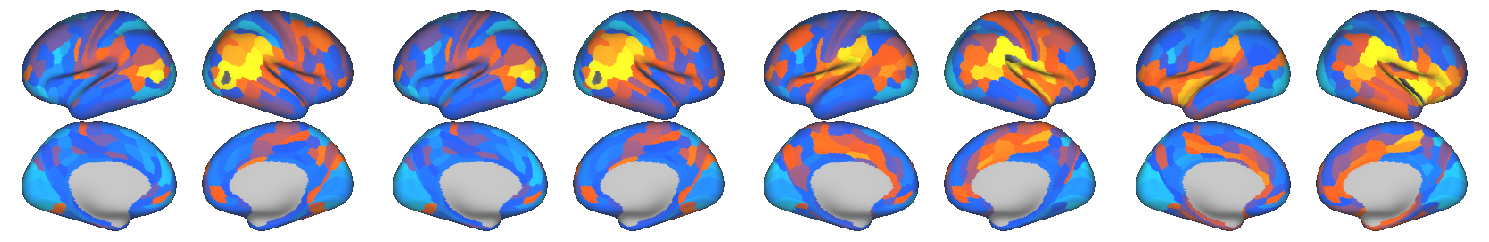

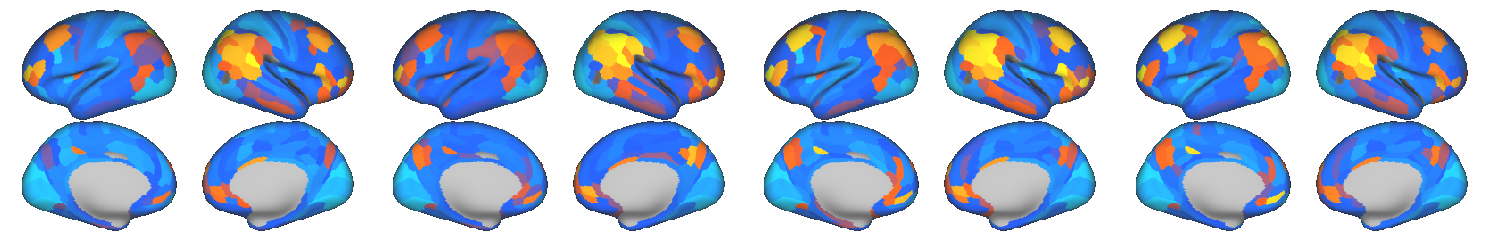

[155 196 201   5  12] [328 144  84 207 324]


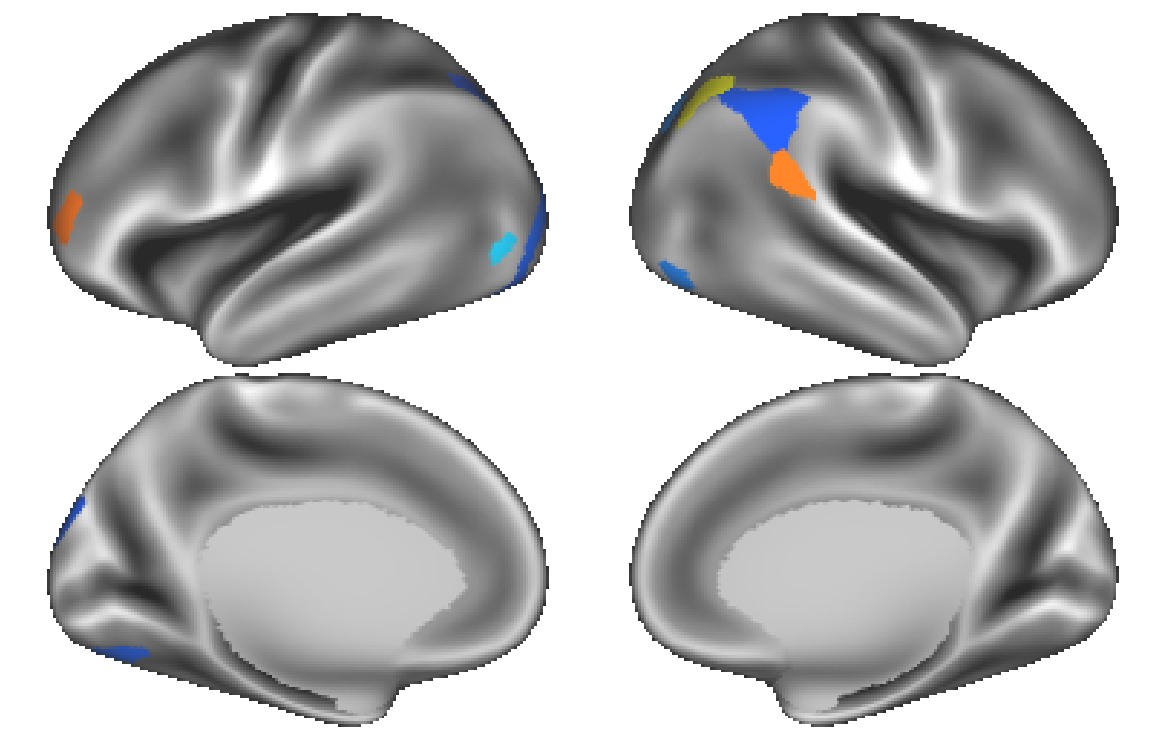

In [39]:
do_brainplots = 1

# brain weight plots
fc_diff = np.zeros((36,718,len(roi_list)))
new_fc_avg = np.zeros((36,718,len(roi_list))) 
for r,roi in enumerate(roi_list):
    real_fc = fc[fc_task]['SCHZ'][roi,:,:].copy()
    fc_diff[:,:,r] = new_fc[:,:,r] - real_fc.T 

if do_brainplots:
    data = np.zeros((718,4))
    data[:,0] = np.mean(new_fc[:,:,1],axis=0)
    data[:,1] = np.mean(new_fc[:,:,1],axis=0)
    data[:,2] = np.mean(new_fc[:,:,2],axis=0)
    data[:,3] = np.mean(new_fc[:,:,3],axis=0)
    wb_brain_plots(data)

    data[:,0] = np.mean(fc_diff[:,:,0],axis=0)
    data[:,1] = np.mean(fc_diff[:,:,1],axis=0)
    data[:,2] = np.mean(fc_diff[:,:,2],axis=0)
    data[:,3] = np.mean(fc_diff[:,:,3],axis=0)
    wb_brain_plots(data)

# average across subjects and regions
fc_diff_avg = np.mean(np.mean(fc_diff,axis=0),axis=1)
n_regions = 5
# cortex only because application to stim methods...
neg_list = np.argsort(fc_diff_avg[0:360])[0:n_regions]
pos_list = np.argsort(fc_diff_avg[0:360])[-n_regions::]

print(neg_list,pos_list)
fc_diff_avg_thresh = np.zeros(np.shape(fc_diff_avg))
fc_diff_avg_thresh[neg_list] = fc_diff_avg[neg_list]
fc_diff_avg_thresh[pos_list] = fc_diff_avg[pos_list]
if do_brainplots:
    wb_brain_plots(fc_diff_avg_thresh.reshape(-1,1))

# save dscalar files out (slow)
if do_brainplots:
    for r,roi in enumerate(roi_list):
        # save connectome wb files in the figure folder
        mf.map_to_surface(np.mean(fc_diff[:,:,r],axis=0),figure_dir+'SimFC-diff-roi-'+str(roi))
    mf.map_to_surface(fc_diff_avg_thresh.reshape(-1,1),figure_dir+'SimFC-top-regions')

## Activation plot

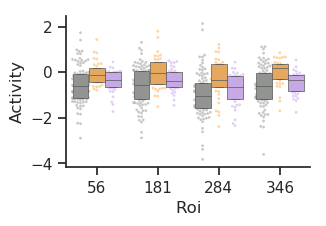

In [40]:
df_plot = pd.DataFrame()

for i,roi in enumerate(roi_list):
    
    # HC empirical
    df = pd.DataFrame()
    df['Activity'] = np.mean(activity[task]['CTRL'][roi,6:12,:],axis=0) - np.mean(activity[task]['CTRL'][roi,0:6,:],axis=0)
    df['Group'] = ['HC-emp'] * len(df)
    df['Roi'] = roi
    df_plot = pd.concat([df_plot,df])
    
    # SZ empirical
    df = pd.DataFrame()
    df['Activity'] = np.mean(activity[task]['SCHZ'][roi,6:12,:],axis=0) - np.mean(activity[task]['SCHZ'][roi,0:6,:],axis=0)
    df['Group'] = ['SZ-emp'] * len(df)
    df['Roi'] = roi
    df_plot = pd.concat([df_plot,df])
    
    # SZ intervention  
    df = pd.DataFrame()
    df['Activity'] = np.mean(altered_actflow[:,6:12,i] - altered_actflow[:,0:6,i],axis=1)
    df['Group'] = ['SZ-AF-FC'] * len(df)
    df['Roi'] = roi
    df_plot = pd.concat([df_plot,df])

sns.set(style='ticks')
FC_PAL = sns.xkcd_palette(['grey','light orange','lavender'])
plt.figure(figsize=cm2inch(8.0,5.0))
g=sns.boxplot(y='Activity',x='Roi',hue='Group',data=df_plot,linewidth=0.5,fliersize=0,whis=0,zorder=1,palette=FC_PAL)
sns.swarmplot(y='Activity',x='Roi',hue='Group',data=df_plot,size=2,dodge=True,zorder=0,alpha=0.5,palette=FC_PAL)
g.get_legend().remove()
sns.despine()
plt.savefig(figure_dir+'SimFC-activity.svg',dpi=600)

## Behaviour plot

### With altered data

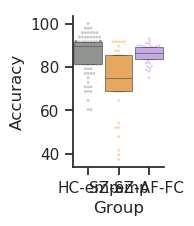

In [47]:
df_plot = pd.DataFrame()

#HC emprical
df = pd.DataFrame()
df['Accuracy'] = np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0) *100
df['Group'] = ['HC-emp'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

# SZ empirical
df = pd.DataFrame()
df['Accuracy'] = np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0) * 100
df['Group'] = ['SZ-emp'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

# SZ intervention
df = pd.DataFrame()
df['Accuracy'] = behav_pred_treat * 100
df['Group'] = ['SZ-AF-FC'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

sns.set(style='ticks')
FC_PAL = sns.xkcd_palette(['grey','light orange','lavender'])
plt.figure(figsize=cm2inch(3.0,5.0))
sns.boxplot(y='Accuracy',x='Group',data=df_plot,linewidth=0.5,fliersize=0,whis=0,zorder=1,width=0.9,palette=FC_PAL)
sns.swarmplot(y='Accuracy',x='Group',data=df_plot,size=2,dodge=True,zorder=0,alpha=0.5,palette=FC_PAL)
sns.despine()
plt.savefig(figure_dir+'SimFC-behav.svg',dpi=600)

### With original activity flow data (should resemble original data)

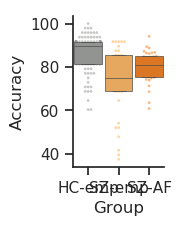

In [58]:
df_plot = pd.DataFrame()

#HC emprical
df = pd.DataFrame()
df['Accuracy'] = np.mean(np.mean(accuracy['scap']['CTRL'],axis=0),axis=0) *100
df['Group'] = ['HC-emp'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

# SZ empirical
df = pd.DataFrame()
df['Accuracy'] = np.mean(np.mean(accuracy['scap']['SCHZ'],axis=0),axis=0) * 100
df['Group'] = ['SZ-emp'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

# SZ intervention
df = pd.DataFrame()
df['Accuracy'] = behav_pred_af * 100
df['Group'] = ['SZ-AF'] * len(df)
df_plot = pd.concat([df_plot,df],sort=False)

sns.set(style='ticks')
FC_PAL = sns.xkcd_palette(['grey','light orange','orange'])
plt.figure(figsize=cm2inch(3.0,5.0))
sns.boxplot(y='Accuracy',x='Group',data=df_plot,linewidth=0.5,fliersize=0,whis=0,zorder=1,width=0.9,palette=FC_PAL)
sns.swarmplot(y='Accuracy',x='Group',data=df_plot,size=2,dodge=True,zorder=0,alpha=0.5,palette=FC_PAL)
sns.despine()
plt.savefig(figure_dir+'SimFC-behav-afOnly.svg',dpi=600)